<a href="https://colab.research.google.com/github/BR-Lab/ML-algorithm/blob/main/Regularization_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization 실습

## 0.Introduction

<분석 모델>
*  정규화 모델 구축(Linear Regression, Ridge, LASSO, ElasticNet 비교)
*  데이터 전처리 후 model들 구축(hyperparameter 탐색)
   * 데이터 전처리: NAN에 대한 처리, categories 이진법 표기(one-hot encoding), 정수형 데이터들에 대한 scaling
*  예측 결과 평가(k-fold validation) & 변수 중요도 해석

<분석 데이터>
*  Housing Price에 대한 data

## 1.import module

In [1]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action = 'ignore')

# 데이터 전처리 패키지
import numpy as np
import pandas as pd

# 기계학습 모델 및 평가
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#데이터 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt

#한글 폰트 설정
plt.rc('font', family = 'Malgun Gothic')

## 2.데이터 불러오기 & 분석 및 전처리

###2.1 data description

<데이터 다운 루트> [kaggle house prices competiton](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt)

<데이터 구조>


*   데이터 : 집가격 예측 데이터
*   관측치 개수: 1460개
*   변수 개수: 80개(설명변수: 79개, 반응변수: 1개)


In [2]:
# load data
data = pd.read_csv('/content/drive/MyDrive/Data/HousePrices_train.csv', index_col='Id')
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# data 결측치, 타입 확인
print(f"관측치 수: {data.shape[0]}\n변수 수: {data.shape[1]}\n")
print(data.info())
print(data.describe())

관측치 수: 1460
변수 수: 80

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null  

###2.2 data 타입 변환(int->str(obj))

*  class나 quality 등과 같이 int형으로 표현됐지만 object형으로 level이 표시되어야 할 경우에 대해 type tranform

In [4]:
for categ in ['MSSubClass', 'OverallQual', 'OverallCond']:
  data[categ] = data[categ].astype(str)

###2.3 y값의 분포 확인

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


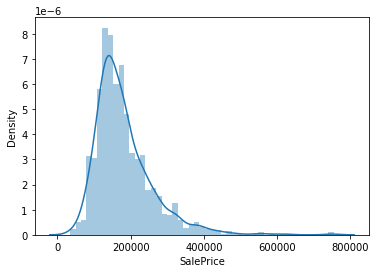

In [5]:
f = sns.distplot(data['SalePrice'])

###2.4 train, test 테이터 분리(validation을 위해 train data내에서 data분리)

In [6]:
X = data.drop('SalePrice', axis=1)
Y = data['SalePrice']

display(X.head(3))
display(Y.head(3))

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


Id
1    208500
2    181500
3    223500
Name: SalePrice, dtype: int64

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2021)

###2.5 NULL 데이터 확인 및 대체

*  Null, NAN, NA라고 들어와있는 data 개수 확인
*  Target 값일 경우 그 데이터는 제외
*  Numerical 타입인 경우 평균값(일반적으로), categorical 타입일 경우 'NaN'으로 대체

In [8]:
NaNInfo = X_train.isnull().sum()
NaNInfo = NaNInfo.sort_values(ascending=False)
NaNInfo = NaNInfo[NaNInfo>0]
NaNInfo

PoolQC          1018
MiscFeature      984
Alley            957
Fence            823
FireplaceQu      477
LotFrontage      190
GarageCond        54
GarageType        54
GarageYrBlt       54
GarageFinish      54
GarageQual        54
BsmtExposure      22
BsmtFinType1      21
BsmtCond          21
BsmtQual          21
BsmtFinType2      21
MasVnrArea         6
MasVnrType         6
Electrical         1
dtype: int64

In [9]:
for col in NaNInfo.index:
  print(f"{col}:{data[col].unique().tolist()[:10]}")

PoolQC:[nan, 'Ex', 'Fa', 'Gd']
MiscFeature:[nan, 'Shed', 'Gar2', 'Othr', 'TenC']
Alley:[nan, 'Grvl', 'Pave']
Fence:[nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw']
FireplaceQu:[nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po']
LotFrontage:[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan, 51.0, 50.0]
GarageCond:['TA', 'Fa', nan, 'Gd', 'Po', 'Ex']
GarageType:['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types']
GarageYrBlt:[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993.0, 2004.0, 1973.0, 1931.0, 1939.0]
GarageFinish:['RFn', 'Unf', 'Fin', nan]
GarageQual:['TA', 'Fa', 'Gd', nan, 'Ex', 'Po']
BsmtExposure:['No', 'Gd', 'Mn', 'Av', nan]
BsmtFinType1:['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ']
BsmtCond:['TA', 'Gd', nan, 'Fa', 'Po']
BsmtQual:['Gd', 'TA', 'Ex', nan, 'Fa']
BsmtFinType2:['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ']
MasVnrArea:[196.0, 0.0, 162.0, 350.0, 186.0, 240.0, 286.0, 306.0, 212.0, 180.0]
MasVnrType:['BrkFace', 'None', 'Stone', 'BrkCmn', nan]
Electrical:['SBrkr', 'FuseF', 'FuseA', '

In [10]:
for feature in ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']:
  X_train[feature] = X_train[feature].fillna(X_train[feature].mean())
  X_test[feature] = X_test[feature].fillna(X_test[feature].mean())

for feature in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'MasVnrType', 'Electrical' ]:
  X_train[feature] = X_train[feature].fillna('NaN')
  X_test[feature] = X_test[feature].fillna('NaN')

###2.6 변수 transform

*  category 변수 encoding(vectorizing)
   *  label encoding: 정렬된 기준으로 숫자 할당(정렬된 기준이라 상관관계가 없는데 숫자 차이로 상관관계로 여겨질 수 있어서 잘 사용하지 않음)
   *  one-hot encoding: 범주 조율에 대해 이진값으로 할당(vector 형태로)
   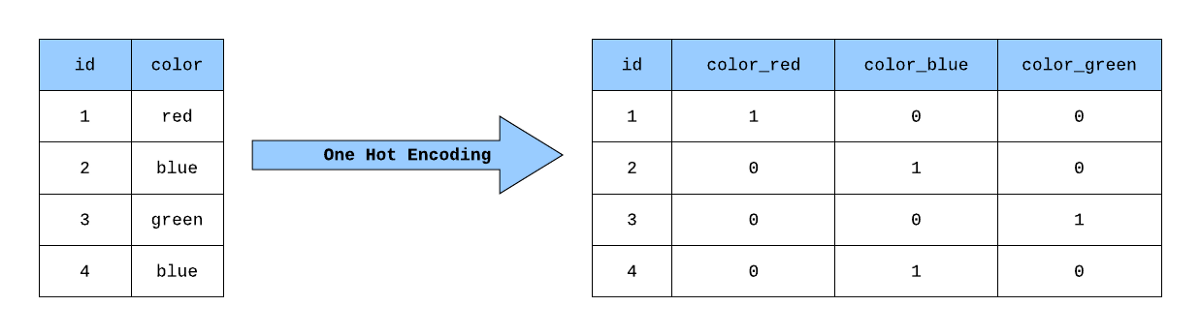 
*  numerical 변수 scaling



> train data로만 transform 해야함



In [11]:
category = list(X_train.select_dtypes(include=[object]))
category[:10]

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood']

In [12]:
vec = DictVectorizer()
vec.fit(X_train[category].to_dict('records'))

scaler = StandardScaler()
scaler.fit(X_train.drop(category, axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
X_category = vec.transform(X_train[category].to_dict('records'))
X_train_category = pd.DataFrame(X_category.toarray(), columns=vec.feature_names_)
display(X_train_category.head())

X_train_without_category = X_train.drop(category, axis=1)
X_scale = scaler.transform(X_train_without_category)
X_train_scale = pd.DataFrame(X_scale, columns=X_train_without_category.columns)
display(X_train_scale.head())

,Alley=Grvl,Alley=NaN,Alley=Pave,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,BldgType=TwnhsE,BsmtCond=Fa,BsmtCond=Gd,BsmtCond=NaN,BsmtCond=Po,BsmtCond=TA,BsmtExposure=Av,BsmtExposure=Gd,BsmtExposure=Mn,BsmtExposure=NaN,BsmtExposure=No,BsmtFinType1=ALQ,BsmtFinType1=BLQ,BsmtFinType1=GLQ,BsmtFinType1=LwQ,BsmtFinType1=NaN,BsmtFinType1=Rec,BsmtFinType1=Unf,BsmtFinType2=ALQ,BsmtFinType2=BLQ,BsmtFinType2=GLQ,BsmtFinType2=LwQ,BsmtFinType2=NaN,BsmtFinType2=Rec,BsmtFinType2=Unf,BsmtQual=Ex,BsmtQual=Fa,BsmtQual=Gd,BsmtQual=NaN,BsmtQual=TA,CentralAir=N,CentralAir=Y,Condition1=Artery,...,OverallQual=9,PavedDrive=N,PavedDrive=P,PavedDrive=Y,PoolQC=Ex,PoolQC=Fa,PoolQC=Gd,PoolQC=NaN,RoofMatl=ClyTile,RoofMatl=CompShg,RoofMatl=Metal,RoofMatl=Roll,RoofMatl=Tar&Grv,RoofMatl=WdShake,RoofMatl=WdShngl,RoofStyle=Flat,RoofStyle=Gable,RoofStyle=Gambrel,RoofStyle=Hip,RoofStyle=Mansard,RoofStyle=Shed,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,Street=Grvl,Street=Pave,Utilities=AllPub,Utilities=NoSeWa
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.001570,-0.053056,0.750385,0.445263,1.506176,0.598808,-0.298245,-0.293608,0.237928,0.096438,2.208475,-0.121615,1.882126,1.089423,-0.243038,0.784468,1.202630,1.390643,-0.20702,0.911636,0.609855,0.644650,1.677918,1.700600,1.625172,0.447993,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,2.067295,-1.332473
1,0.679972,0.066754,0.114431,-0.484927,-0.559450,0.194942,-0.298245,-0.898675,-0.799522,-0.908490,0.881199,-0.121615,0.048758,1.089423,-0.243038,0.784468,1.202630,0.156930,-0.20702,-0.326493,0.609855,-0.164054,0.325527,-0.191876,0.852289,2.416323,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-1.585498,-1.332473
2,0.634030,-0.056239,1.118569,1.032751,0.476005,-0.923128,-0.298245,2.253678,1.126188,0.991132,-0.808682,-0.121615,0.048758,-0.813808,-0.243038,0.784468,-0.792642,0.156930,-0.20702,0.292571,-0.964063,1.112847,1.677918,1.414420,0.349915,-0.430185,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,0.240899,-1.332473
3,-0.055109,-0.045540,-0.320695,-1.121373,-0.559450,0.692335,-0.298245,-0.949482,-0.312930,-0.426535,-0.808682,-0.121615,-0.992159,1.089423,-0.243038,-1.041788,-0.792642,0.156930,-0.20702,-0.326493,-0.964063,-0.717377,-1.026865,-0.810393,0.396288,0.357147,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.489660,-1.332473
4,1.185341,0.049070,-0.153339,1.081709,1.025429,-0.974142,-0.298245,0.364576,-0.806408,1.878136,1.654303,-0.121615,2.732929,-0.813808,-0.243038,0.784468,1.202630,2.624356,-0.20702,2.768828,0.609855,-0.759940,0.325527,0.408177,1.091883,-0.733005,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.124381,1.662112


In [14]:
X_train_final = pd.concat([X_train_scale, X_train_category], axis=1)
X_train_final.tail()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Alley=Grvl,Alley=NaN,Alley=Pave,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,...,OverallQual=9,PavedDrive=N,PavedDrive=P,PavedDrive=Y,PoolQC=Ex,PoolQC=Fa,PoolQC=Gd,PoolQC=NaN,RoofMatl=ClyTile,RoofMatl=CompShg,RoofMatl=Metal,RoofMatl=Roll,RoofMatl=Tar&Grv,RoofMatl=WdShake,RoofMatl=WdShngl,RoofStyle=Flat,RoofStyle=Gable,RoofStyle=Gambrel,RoofStyle=Hip,RoofStyle=Mansard,RoofStyle=Shed,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,Street=Grvl,Street=Pave,Utilities=AllPub,Utilities=NoSeWa
1017,0.909685,0.007070,0.080960,0.592135,-0.55945,1.057939,0.767859,-0.388294,1.057331,0.980878,1.622375,-0.121615,2.047769,-0.813808,-0.243038,0.784468,1.202630,1.390643,-0.20702,1.530700,0.609855,-0.206617,0.325527,0.685125,-0.469341,2.946259,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.124381,0.164819,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1018,0.909685,0.300185,-0.521523,0.934836,-0.55945,-0.344962,2.905925,-0.743944,0.026766,1.655103,-0.808682,-0.121615,0.536275,-0.813808,-0.243038,-1.041788,-0.792642,-1.076783,-0.20702,-0.326493,0.609855,-0.972757,0.325527,-0.025708,-0.763037,-0.733005,4.321087,-0.115265,-0.272777,-0.06189,-0.084569,0.240899,-1.332473,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1019,0.863743,0.081786,1.085098,0.934836,-0.55945,-0.974142,-0.298245,0.710988,-0.462121,-0.782874,1.152584,-0.121615,0.364985,-0.813808,-0.243038,0.784468,1.202630,0.156930,-0.20702,0.292571,-0.964063,1.070283,0.325527,0.412793,-0.763037,0.326865,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,0.606178,-1.332473,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1020,0.000000,-0.284718,0.951213,0.739007,-0.55945,0.158807,-0.298245,-0.626164,-0.567703,-0.900800,1.152584,-0.121615,0.278399,1.089423,-0.243038,0.784468,1.202630,0.156930,-0.20702,0.292571,-0.964063,0.900030,0.325527,0.865141,-0.763037,0.720531,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-1.950778,1.662112,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1021,-0.468592,-0.297982,-0.688879,-1.659904,-0.55945,0.836876,-0.298245,-1.044168,-0.250959,-0.547024,-0.808682,-0.121615,-1.080627,1.089423,-0.243038,-1.041788,-0.792642,-1.076783,-0.20702,-1.564621,-0.964063,0.389270,0.325527,1.682137,-0.763037,-0.733005,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.124381,0.164819,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [15]:
X_category = vec.transform(X_test[category].to_dict('records'))
X_test_category = pd.DataFrame(X_category.toarray(), columns=vec.feature_names_)
display(X_test_category.head())

X_test_without_category = X_test.drop(category, axis=1)
X_scale = scaler.transform(X_test_without_category)
X_test_scale = pd.DataFrame(X_scale, columns=X_test_without_category.columns)
display(X_test_scale.head())

,Alley=Grvl,Alley=NaN,Alley=Pave,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,BldgType=TwnhsE,BsmtCond=Fa,BsmtCond=Gd,BsmtCond=NaN,BsmtCond=Po,BsmtCond=TA,BsmtExposure=Av,BsmtExposure=Gd,BsmtExposure=Mn,BsmtExposure=NaN,BsmtExposure=No,BsmtFinType1=ALQ,BsmtFinType1=BLQ,BsmtFinType1=GLQ,BsmtFinType1=LwQ,BsmtFinType1=NaN,BsmtFinType1=Rec,BsmtFinType1=Unf,BsmtFinType2=ALQ,BsmtFinType2=BLQ,BsmtFinType2=GLQ,BsmtFinType2=LwQ,BsmtFinType2=NaN,BsmtFinType2=Rec,BsmtFinType2=Unf,BsmtQual=Ex,BsmtQual=Fa,BsmtQual=Gd,BsmtQual=NaN,BsmtQual=TA,CentralAir=N,CentralAir=Y,Condition1=Artery,...,OverallQual=9,PavedDrive=N,PavedDrive=P,PavedDrive=Y,PoolQC=Ex,PoolQC=Fa,PoolQC=Gd,PoolQC=NaN,RoofMatl=ClyTile,RoofMatl=CompShg,RoofMatl=Metal,RoofMatl=Roll,RoofMatl=Tar&Grv,RoofMatl=WdShake,RoofMatl=WdShngl,RoofStyle=Flat,RoofStyle=Gable,RoofStyle=Gambrel,RoofStyle=Hip,RoofStyle=Mansard,RoofStyle=Shed,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,Street=Grvl,Street=Pave,Utilities=AllPub,Utilities=NoSeWa
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,-1.157731,-0.221763,-1.927316,-1.708861,-0.559450,-0.542644,-0.298245,0.251415,-0.452940,-0.772620,-0.808682,-0.121615,-1.246270,1.089423,-0.243038,-1.041788,-0.792642,-1.076783,-0.207020,-0.945557,-0.964063,-1.738897,-1.026865,-1.271972,-0.763037,-0.733005,1.249145,-0.115265,-0.272777,-0.06189,-0.084569,-0.124381,1.662112
1,-0.468592,0.007070,-2.395914,0.739007,-0.559450,-0.974142,-0.298245,-1.275109,-2.436032,-1.208431,0.559643,-0.121615,-0.436878,-0.813808,-0.243038,0.784468,-0.792642,0.156930,4.830459,0.292571,-0.964063,-0.049723,-2.379256,-2.195131,0.937306,0.993069,3.152414,-0.115265,-0.272777,-0.06189,-0.084569,0.606178,0.164819
2,0.679972,-0.003717,0.683443,0.739007,1.220898,0.513784,-0.298245,0.995046,1.426865,2.470326,0.885761,-0.121615,2.533404,-0.813808,-0.243038,0.784468,1.202630,1.390643,-0.207020,1.530700,0.609855,0.559523,0.325527,0.302014,-0.763037,-0.233352,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.854940,-0.583827
3,-0.022364,-0.481808,0.482615,0.053604,-0.559450,1.325766,-0.298245,-0.418316,0.898959,0.737337,-0.808682,-0.121615,-0.137591,1.089423,-0.243038,-1.041788,1.202630,-1.076783,-0.207020,-0.326493,0.609855,0.304143,0.325527,-0.141102,-0.763037,0.478275,-0.353608,-0.115265,3.130109,-0.06189,-0.084569,2.067295,-1.332473
4,0.450259,-0.094614,0.181374,-0.387012,1.342405,0.484025,-0.298245,0.258343,0.662549,0.432269,-0.808682,-0.121615,-0.361586,-0.813808,4.114587,0.784468,-0.792642,-1.076783,-0.207020,-0.326493,0.609855,-0.078927,0.325527,0.712820,-0.763037,-0.490749,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.854940,0.913466


In [16]:
X_test_final = pd.concat([X_test_scale, X_test_category], axis=1)
X_test_final.tail()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Alley=Grvl,Alley=NaN,Alley=Pave,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,...,OverallQual=9,PavedDrive=N,PavedDrive=P,PavedDrive=Y,PoolQC=Ex,PoolQC=Fa,PoolQC=Gd,PoolQC=NaN,RoofMatl=ClyTile,RoofMatl=CompShg,RoofMatl=Metal,RoofMatl=Roll,RoofMatl=Tar&Grv,RoofMatl=WdShake,RoofMatl=WdShngl,RoofStyle=Flat,RoofStyle=Gable,RoofStyle=Gambrel,RoofStyle=Hip,RoofStyle=Mansard,RoofStyle=Shed,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,Street=Grvl,Street=Pave,Utilities=AllPub,Utilities=NoSeWa
433,-0.022364,-0.141035,0.683443,0.347348,0.338648,-0.974142,-0.298245,-0.388294,-1.554658,-0.905927,0.719281,-0.121615,-0.083004,-0.813808,-0.243038,0.784468,1.202630,0.156930,-0.20702,0.292571,0.609855,0.559523,0.325527,-0.385740,0.009846,-0.354480,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,0.240899,-0.583827,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
434,-2.260353,-0.816039,0.014017,-0.631799,-0.559450,-0.655301,2.513458,-1.275109,-0.990028,-1.372501,-0.808682,-0.121615,-1.686730,1.089423,-0.243038,-1.041788,-0.792642,-2.310496,-0.20702,-2.183685,-0.964063,-0.049723,-2.379256,-2.195131,-0.021069,-0.369621,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.489660,1.662112,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
435,1.093455,-0.028121,1.252454,1.179623,-0.559450,-0.974142,-0.298245,1.556235,0.377938,0.155401,-0.808682,-0.121615,-0.564875,-0.813808,-0.243038,0.784468,-0.792642,0.156930,-0.20702,-0.326493,-0.964063,1.283100,1.677918,1.220557,-0.763037,-0.187929,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.489660,1.662112,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
436,-1.754984,-0.549981,0.884270,0.641092,1.131088,0.866635,-0.298245,-0.494527,0.327443,0.099002,-0.808682,-0.121615,-0.606286,1.089423,-0.243038,0.784468,-0.792642,-1.076783,-0.20702,-0.945557,-0.964063,0.814903,0.325527,-0.293424,-0.763037,3.006823,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,-0.124381,0.913466,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
437,0.220546,0.245806,-2.630213,0.739007,-0.559450,-0.974142,-0.298245,1.581638,0.403186,0.911661,2.051117,-0.121615,2.350821,-0.813808,-0.243038,2.610723,1.202630,0.156930,-0.20702,1.530700,0.609855,0.389270,0.325527,1.866768,0.048490,6.867778,-0.353608,-0.115265,-0.272777,-0.06189,-0.084569,0.240899,0.164819,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [17]:
X_train, Y_train = X_train_final.values, Y_train.values
X_test, Y_test = X_test_final.values, Y_test.values

## 3.model 구축

sklearn.linear_model 사용

Linear regression vs Ridge vs LASSO 계수 비교


<br>
Linear Regression

*   linear에 대한 Loss ft을 최소 시키는 계수 찾기
*   $argmin_\beta\sum_{i=1}^m(y_i-x_i\beta)^2$

<br>
Ridge

*   $\beta에 대해 L_2-norm 제약을 둠으로써 bias는 커질수 있지만 variance를 낮춰 \beta값을 줄이는 효과(shrink)$
*   $argmin_\beta\{\sum_{i=1}^m(y_i-x_i\beta)^2+\lambda\sum_{j=1}^p\beta_j^2\}$

<br>
LASSO(Least Absolute Shrink&Selection Operator)

*   $\beta에 대해 L_1-norm$ 제약을 둠으로써 shrink & selection
*   미분 불가능해서 closed form solution 불가능. Numerical optimization solution 이용 필요
*   변수들 간 상관관계 클수록 예측의 성능이 저하됨.
*   $argmin_\beta\{\sum_{i=1}^m(y_i-x_i\beta)^2+\lambda\sum_{j=1}^p|\beta_j|\}$

<br>
ElasticNet

*   Ridge + LASSO
*   $argmin_\beta\{\sum_{i=1}^m(y_i-x_i\beta)^2+\lambda_1\sum_{j=1}^p|\beta_j|+\lambda_2\sum_{j=1}^p\beta_j^2\}$
*   $|\hat\beta_i^{enet}-\hat\beta_j^{enet}| ≤ \frac{\sum_i|y_i|}{\lambda_2}\sqrt{2(1-\rho_{ij}}),   \rho_{ij}: x_i와 x_j의 상관계수$
    *   $if   \rho_{ij}=1, |\hat\beta_i^{enet}-\hat\beta_j^{enet}| ≤ 0 -> \hat\beta_i^{enet}=\hat\beta_j^{enet}$

### 3.1 Linear regression vs Ridge vs LASSO 계수 비교


In [18]:
model_LR = LinearRegression(n_jobs=-1)
model_LR.fit(X_train, Y_train)
display(pd.DataFrame(model_LR.coef_, index=X_test_final.columns, columns=['Linear regression 계수']))

,Linear regression 계수
LotFrontage,2.401718e+03
LotArea,6.642534e+03
YearBuilt,1.047461e+04
YearRemodAdd,2.052841e+03
MasVnrArea,3.333242e+03
...,...
SaleType=WD,1.988507e+15
Street=Grvl,-2.567313e+14
Street=Pave,-2.567313e+14
Utilities=AllPub,-2.152169e+14


In [19]:
model_Ridge1 = Ridge(alpha=0.0001, random_state=1)
model_Ridge2 = Ridge(alpha=100.0, random_state=1)
model_LASSO1 = Lasso(alpha=0.0001, random_state=1)
model_LASSO2 = Lasso(alpha=100.0, random_state=1)

model_Ridge1.fit(X_train, Y_train)
model_Ridge2.fit(X_train, Y_train)
model_LASSO1.fit(X_train, Y_train)
model_LASSO2.fit(X_train, Y_train)

Lasso(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

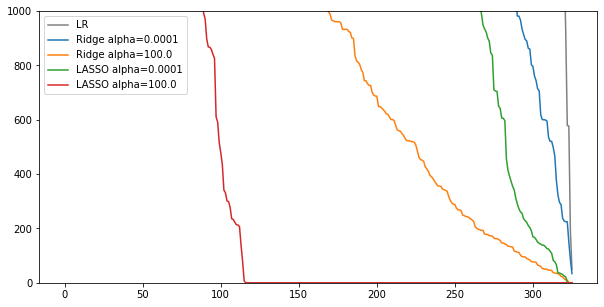

In [20]:
plt.figure(figsize=(10,5))
plt.plot(sorted(np.abs(model_LR.coef_))[::-1], label='LR', c='gray')
plt.plot(sorted(np.abs(model_Ridge1.coef_))[::-1], label='Ridge alpha=0.0001')
plt.plot(sorted(np.abs(model_Ridge2.coef_))[::-1], label='Ridge alpha=100.0')
plt.plot(sorted(np.abs(model_LASSO1.coef_))[::-1], label='LASSO alpha=0.0001')
plt.plot(sorted(np.abs(model_LASSO2.coef_))[::-1], label='LASSO alpha=100.0')

plt.legend()
plt.ylim((-0.1,1000))
plt.show()

alpha가 클수록 성능이 좋다는걸 확인할 수 있음

###3.2 k-fold cross validation으로 alpha(=lambda)값 찾기

In [21]:
cv = 5
max_iter = 5000
n_trials = 50

# 일정한 비율로 나눈 alpha값 생성
def myrange(start, end, step):
  r = start
  while(r<end):
    yield r
    r+= step

alpha_list = list(reversed([round(i,2) for i in myrange(0.01, 10.0, 0.1)]))    

In [22]:
model_Lasso = LassoCV(alphas=alpha_list, cv=cv, n_jobs=-1, random_state=1, max_iter=max_iter)
model_Lasso.fit(X_train, Y_train)

LassoCV(alphas=[9.91, 9.81, 9.71, 9.61, 9.51, 9.41, 9.31, 9.21, 9.11, 9.01,
                8.91, 8.81, 8.71, 8.61, 8.51, 8.41, 8.31, 8.21, 8.11, 8.01,
                7.91, 7.81, 7.71, 7.61, 7.51, 7.41, 7.31, 7.21, 7.11, 7.01, ...],
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=5000,
        n_alphas=100, n_jobs=-1, normalize=False, positive=False,
        precompute='auto', random_state=1, selection='cyclic', tol=0.0001,
        verbose=False)

In [23]:
#최적의 alpha값
model_Lasso.alpha_

9.91

In [24]:
# 학습된 모델을 사용해서 예측값 출력
pred_train_LR = model_LR.predict(X_train)
pred_test_LR = model_LR.predict(X_test)
pred_train_Lasso = model_Lasso.predict(X_train)
pred_test_Lasso = model_Lasso.predict(X_test)

In [25]:
train_rmse_LR = np.sqrt(mean_squared_error(Y_train, pred_train_LR))
train_mse_LR = mean_absolute_error(Y_train, pred_train_LR)
train_r2_LR = r2_score(Y_train, pred_train_LR)

test_rmse_LR = np.sqrt(mean_squared_error(Y_test, pred_test_LR))
test_mse_LR = mean_absolute_error(Y_test, pred_test_LR)
test_r2_LR = r2_score(Y_test, pred_test_LR)

train_rmse_Lasso = np.sqrt(mean_squared_error(Y_train, pred_train_Lasso))
train_mse_Lasso = mean_absolute_error(Y_train, pred_train_Lasso)
train_r2_Lasso = r2_score(Y_train, pred_train_Lasso)

test_rmse_Lasso = np.sqrt(mean_squared_error(Y_test, pred_test_Lasso))
test_mse_Lasso = mean_absolute_error(Y_test, pred_test_Lasso)
test_r2_Lasso = r2_score(Y_test, pred_test_Lasso)

In [26]:
results = pd.DataFrame(index=['rmse', 'mse', 'r2'], columns=['LR train', 'LR test', 'Lasso train', 'Lasso test'])

In [27]:
results.loc['rmse', 'LR train'] = train_rmse_LR
results.loc['mse', 'LR train'] = train_mse_LR
results.loc['r2', 'LR train'] = train_r2_LR

results.loc['rmse', 'LR test'] = test_rmse_LR
results.loc['mse', 'LR test'] = test_mse_LR
results.loc['r2', 'LR test'] = test_r2_LR

results.loc['rmse', 'Lasso train'] = train_rmse_Lasso
results.loc['mse', 'Lasso train'] = train_mse_Lasso
results.loc['r2', 'Lasso train'] = train_r2_Lasso

results.loc['rmse', 'Lasso test'] = test_rmse_Lasso
results.loc['mse', 'Lasso test'] = test_mse_Lasso
results.loc['r2', 'Lasso test'] = test_r2_Lasso

In [28]:
results

,LR train,LR test,Lasso train,Lasso test
rmse,19574.8,1.46056e+15,19789.5,25547.4
mse,12292.3,1.4547e+14,12584.5,16353.6
r2,0.94067,-3.59657e+20,0.939362,0.889962


###3.3 model 비교 선택


In [29]:
# dict with optimal models
models = {} #dict{}

# find optimal value of alpha
n_trials = 20
alpha_list = 10 ** np.linspace(-3,3,n_trials)

# # of folds for cv
cv = 5

# find optimal value of l1(for ElasticNet)
alpha_list = list(reversed([round(i,2) for i in myrange(0.01,10.0,0.1)]))
l1_list = list(reversed([round(i,2) for i in myrange(0,1,0.1)]))

max_iter = 5000

In [30]:
# fine optimal Lasso model
model = LassoCV(alphas=alpha_list, cv=cv, n_jobs=-1, random_state=1, max_iter=max_iter)
model.fit(X_train, Y_train)
models['Lasso'] = Lasso(alpha=model.alpha_, max_iter=max_iter)

In [31]:
# fine optimal Ridge model
model = RidgeCV(alphas=alpha_list, cv=cv)
model.fit(X_train, Y_train)
models['Ridge'] = Ridge(alpha=model.alpha_)

In [32]:
# fine optimal ElasticNet model
model = ElasticNetCV(alphas=alpha_list, l1_ratio=l1_list, 
                                cv=cv, n_jobs=-1, random_state=1, max_iter=max_iter)
model.fit(X_train, Y_train)
models['ElasticNet'] = ElasticNet(alpha=model.alpha_, l1_ratio = model.l1_ratio_, max_iter=max_iter)

In [33]:
for name in models.keys():
  print(models[name])
  print('-'*100)

Lasso(alpha=9.91, copy_X=True, fit_intercept=True, max_iter=5000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------------------------------------------------------------------------------------
Ridge(alpha=6.51, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------------------------------------------------------------------------------------
ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.2,
           max_iter=5000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------------------------------------------------------------------------------------


In [34]:
kf = KFold(cv, shuffle=True, random_state=1)
kf

KFold(n_splits=5, random_state=1, shuffle=True)

In [35]:
score = {}
for name in models.keys():
  if name not in score:
    score[name] = []

  reg = models[name]
  for i_train, i_valid in kf.split(X_train):
    reg.fit(X_train[i_train], Y_train[i_train])
    
    y_pred = reg.predict(X_train[i_valid])
    RMSE = np.sqrt(mean_squared_error(Y_train[i_valid], y_pred))
    score[name].append(RMSE)

In [36]:
score

{'ElasticNet': [48355.7562516433,
  27424.49898980395,
  52616.89005871897,
  26443.93050840967,
  32237.56404565049],
 'Lasso': [41204.056090292805,
  24406.855352563158,
  52724.659088112996,
  25677.064668282066,
  60371.02002502065],
 'Ridge': [48355.73807396645,
  27423.140104525817,
  52616.16061248406,
  26448.235704431656,
  32245.275256021778]}

In [37]:
results = pd.DataFrame(score)

,mean,std
Lasso,40876.731045,15990.579310
Ridge,37417.709950,12223.013479
ElasticNet,37415.727971,12224.748723


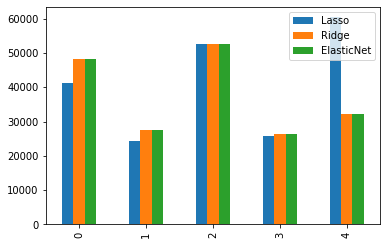

In [38]:
ax = results.plot.bar()
pd.concat([results.mean(), results.std()], axis=1, keys=['mean', 'std'])

값이 작을수록 성능이 좋은건데 ElasticNet의 평균값이 가장 작으므로 

선택된 model은 "ElasticNet"

###3.4 최종 모델 학습, 결과 출력, 성능평가

In [39]:
model = models['ElasticNet'].fit(X_train,Y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [40]:
rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(Y_test, pred_test))
r2_train = r2_score(Y_train, pred_train)
r2_test = r2_score(Y_test, pred_test)

print(f"train rmse: {rmse_train: .4f}")
print(f"test rmse: {rmse_test: .4f}")
print(f"train r2: {r2_train: .4f}")
print(f"test r2: {r2_test: .4f}")

train rmse:  25063.0804
test rmse:  26428.7695
train r2:  0.9027
test r2:  0.8822


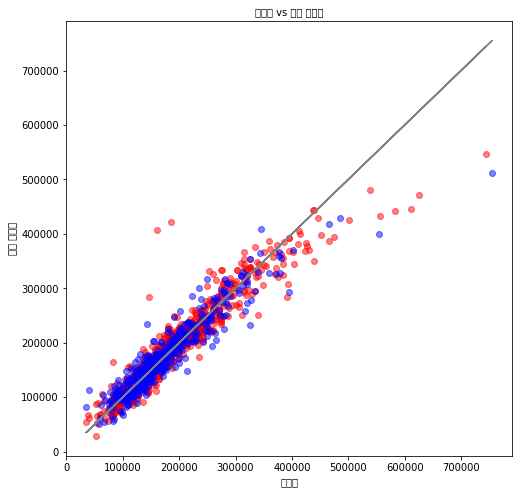

In [41]:
# 예측 결과 plotting
plt.figure(figsize=(8,8))
plt.title("실제값 vs 모델 출력값", fontsize=10)
plt.scatter(Y_train, pred_train, c='red', alpha=0.5) #alpha는 투명도, 0될수록 투명
plt.scatter(Y_test, pred_test, c='blue', alpha=0.5)

plt.plot(Y_test, Y_test, c='gray')
plt.plot(Y_train, Y_train, c='gray')
plt.xlabel('실제값', size=10)
plt.ylabel('모델 출력값', size=10)

plt.show()

In [42]:
# 계수값의 중요도
model = models['ElasticNet'].fit(X_train, Y_train)

coef_df = pd.DataFrame(model.coef_.reshape(-1,1), index=X_test_final.columns, columns=['coefficients'])
coef_df.to_csv('coef.csv')
coef_df

,coefficients
LotFrontage,-3255.873629
LotArea,5544.229309
YearBuilt,8405.871420
YearRemodAdd,1632.485538
MasVnrArea,3197.607688
...,...
SaleType=WD,-8285.050781
Street=Grvl,-6405.206988
Street=Pave,6405.206986
Utilities=AllPub,2793.578106


In [43]:
coefficients = np.abs(coef_df.coefficients)
index = np.argsort(coefficients)[::-1]
print(index)

Utilities=NoSeWa    286
Utilities=AllPub    294
Street=Pave         259
Street=Grvl         266
SaleType=WD         292
                   ... 
MasVnrArea          177
YearRemodAdd        288
YearBuilt            88
LotArea              30
LotFrontage         184
Name: coefficients, Length: 326, dtype: int64


In [44]:
importance = coefficients[index]
columns = [list(coef_df.index)[i] for i in index]

importance = importance[importance>0]

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


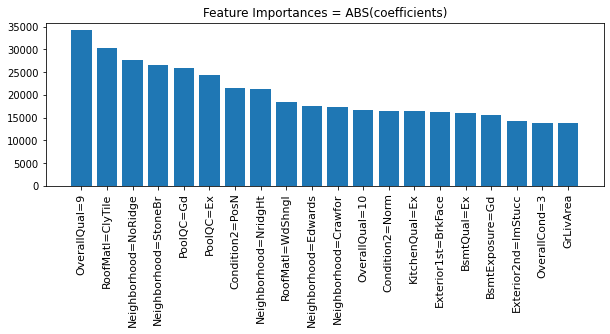

In [45]:
num_print = 20

plt.figure(figsize=(10,3))
plt.title("Feature Importances = ABS(coefficients)")
plt.bar(range(num_print), importance[:num_print], align='center')
plt.xticks(range(num_print), columns[:num_print], rotation=90, fontsize=11)

plt.show()

EOD